In [1]:
# Misc imports
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')
import torch
torch.set_printoptions(linewidth=200)
import seaborn as sns
sns.set_style("darkgrid")
import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
       '/storage'
))
import yaml
from pathlib import Path
# Local imports
from ese.scripts.utils import get_option_product
from ese.experiment.analysis.run_inference import get_cal_stats
from ese.experiment.analysis.analysis_utils.submit_utils import get_ese_inference_configs
# Ionpy imports
from ionpy.util import Config
from ionpy.analysis import ResultsLoader

# Define some useful paths.
scratch_root = Path("/storage/vbutoi/scratch/ESE")
code_root = Path("/storage/vbutoi/projects/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 2
# For using yaml configs.
%load_ext yamlmagic

/storage/vbutoi/libraries/pylot/pandas/register.py:47: UserWarning: registration of accessor <class 'pylot.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'fillNA' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.
  register_series_accessor(method.__name__)(AccessorMethod)
/storage/vbutoi/libraries/pylot/pandas/register.py:47: UserWarning: registration of accessor <class 'pylot.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'isNA' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.
  register_series_accessor(method.__name__)(AccessorMethod)
/storage/vbutoi/libraries/pylot/pandas/register.py:47: UserWarning: registration of accessor <class 'pylot.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'notNA' for type <class 'pandas.core.series.Series'> is overridi

In [2]:
%%yaml inference_config

log:
    root: '?'
    gether_inference_stats: True
    summary_compute_global_metrics: True
    min_fg_pixels: 0 
    log_interval: 20 
    log_image_stats: True 
    log_pixel_stats: True 
    track_ensemble_member_scores: False 

experiment:
    exp_root: '?'
    seed: 42

dataloader:
    batch_size: 1 
    num_workers: 0
    pin_memory: True 

<IPython.core.display.Javascript object>

In [3]:
%%yaml calibration_cfg 

local_calibration:
    num_prob_bins: 15
    neighborhood_width: 3
    square_diff: False 

global_calibration:
    num_prob_bins: 15
    num_classes: '?' 
    neighborhood_width: 3
    square_diff: False 
    loss_weights: None 

<IPython.core.display.Javascript object>

In [4]:
%%yaml standard_model_cfg 

# For standard datasets
#####################################
data:
    splits: ('val', 'cal')
    preload: False 

ensemble:
    combine_fn: '?'
    combine_quantity: '?'
    member_temps: None
    member_w_metric: None
    member_paths: None
    normalize: False

model:
    _type: "standard"
    calibrator: '?'
    pretrained_exp_root : None
    checkpoint: 'max-val-dice_score' 
    pretrained_select_metric: "val-dice_score"

<IPython.core.display.Javascript object>

In [5]:
%%yaml incontext_model_cfg 

# # For incontext datasets
####################################
data:
    splits: ('val',)
    preload: False 

ensemble:
    combine_fn: '?'
    combine_quantity: '?'
    normalize: False

model:
    _type: "incontext"
    _attr:
        model: 'universeg.experiment.models.QCUNet3'
        data_support_size: 64
        mix_filters: (64, 64, 64, 64)
    calibrator: None
    pretrained_exp_root : None
    checkpoint: "max-val_od-dice_score"

<IPython.core.display.Javascript object>

In [6]:
# exp_name = '04_05_24_RandomShapes_Evaluation'
# group_dict = {
#     "dataset": "Shapes",
#     "exp_group": exp_name,
#     "model_type": "standard",
#     "base_models_group": "03_26_24_RandomCircles_MassiveEnsemble",
#     "calibrated_models_group": "03_26_24_RandomCircles_MassiveEnsemble_CE_Calibrated",
#     "scratch_root": "/storage/vbutoi/scratch/ESE"
# }

exp_name = '04_04_24_WBC_UniverSeg_Inference'
group_dict = {
    "dataset": "WBC",
    "exp_group": exp_name,
    "model_type": "incontext",
    "base_models_group": "QC3Net_SupportSetAblation",
    "scratch_root": "/storage/vbutoi/scratch/UniverSeg"
}

In [7]:
%%yaml submit_cfg_args

submit_opts:
    seed: 42
    gather_sub_runs: False
    max_ensemble_samples: 1 
    ens_cfg_options:
        - ('mean', 'probs')
        - ('max', 'probs')
    num_ens_membs:
        # - 1
        # - 2
        - 4
        # - 8
        # - 16
        # - 32

<IPython.core.display.Javascript object>

In [8]:
%%yaml inference_config_opts

calibrator:
    - Uncalibrated
    # - TempScaling
    # - LTS

do_ensemble:
    - True
    # - False

<IPython.core.display.Javascript object>

### Standard Calibrators.

In [9]:
inference_func = get_cal_stats
# Get the configs for the different runs.
option_set = get_ese_inference_configs(
    group_dict=group_dict,
    inf_cfg_opts=inference_config_opts,
    base_cfg_args=submit_cfg_args
)

Set seed: 42


In [10]:
len(option_set)

2

In [11]:
# Load the inference cfg from local.
##################################################
inf_cfg_root = code_root / "ese" / "experiment" / "configs" / "inference"

##################################################
with open(inf_cfg_root / "datasets" / f"{group_dict['dataset']}.yaml", 'r') as file:
    dataset_inference_cfg = yaml.safe_load(file)
with open(inf_cfg_root / "Calibration_Metrics.yaml", 'r') as file:
    cal_metrics_cfg = yaml.safe_load(file)

##################################################
base_cfg = Config(inference_config).update([calibration_cfg, dataset_inference_cfg, cal_metrics_cfg])

##################################################
# If this is an incontext model we need to update the base_cfg with the incontext model cfg.
if group_dict['model_type'] == 'incontext':
    base_cfg = base_cfg.update([incontext_model_cfg])
elif group_dict['model_type'] == 'standard':
    base_cfg = base_cfg.update([standard_model_cfg])
else:
    raise ValueError(f"Unknown model type {group_dict['model_type']}")

# Get the configs
cfgs = get_option_product(exp_name, option_set, base_cfg)

## Running Jobs

In [12]:
from ese.experiment.analysis.run_inference import get_cal_stats

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

/storage/vbutoi/libraries/pylot/util/libcheck.py:49: UserWarning: Intel MKL extensions not available for NumPy
  warn("Intel MKL extensions not available for NumPy")
/storage/vbutoi/libraries/pylot/util/libcheck.py:57: UserWarning: Using slow Pillow instead of Pillow-SIMD
  warn("Using slow Pillow instead of Pillow-SIMD")


Set seed: 42
Running:

data:
  input_type: image
  label: 1
  preload: false
  resolution: 128
  slicing: midslice
  splits: ('val',)
  task: WBC/CV/EM/0
dataloader:
  batch_size: 1
  num_workers: 0
  pin_memory: true
dataset:
  _class: universeg.experiment.datasets.MultiBinarySegment2D
  augmentations: null
  label: 1
  min_label_density: 3e-3
  preload: false
  resolution: 128
  return_data_id: true
  samples_per_epoch: 1000
  slicing: midslice
  support_size: 64
  task: WBC/CV/EM/0
  version: v4.2
ensemble:
  combine_fn: mean
  combine_quantity: probs
  normalize: false
  num_members: 4
experiment:
  dataset_name: WBC
  exp_root: /storage/vbutoi/scratch/UniverSeg/inference/04_04_24_WBC_UniverSeg_Inference
  pretrained_seed: 42
  seed: 42
global_cal_metrics:
- ECE:
    _fn: ese.experiment.metrics.ece.ece_loss
    cal_type: toplabel
- Edge-ECE:
    _fn: ese.experiment.metrics.ece.edge_ece_loss
    cal_type: toplabel
- CW-ECE:
    _fn: ese.experiment.metrics.ece.cw_ece_loss
    cal_typ

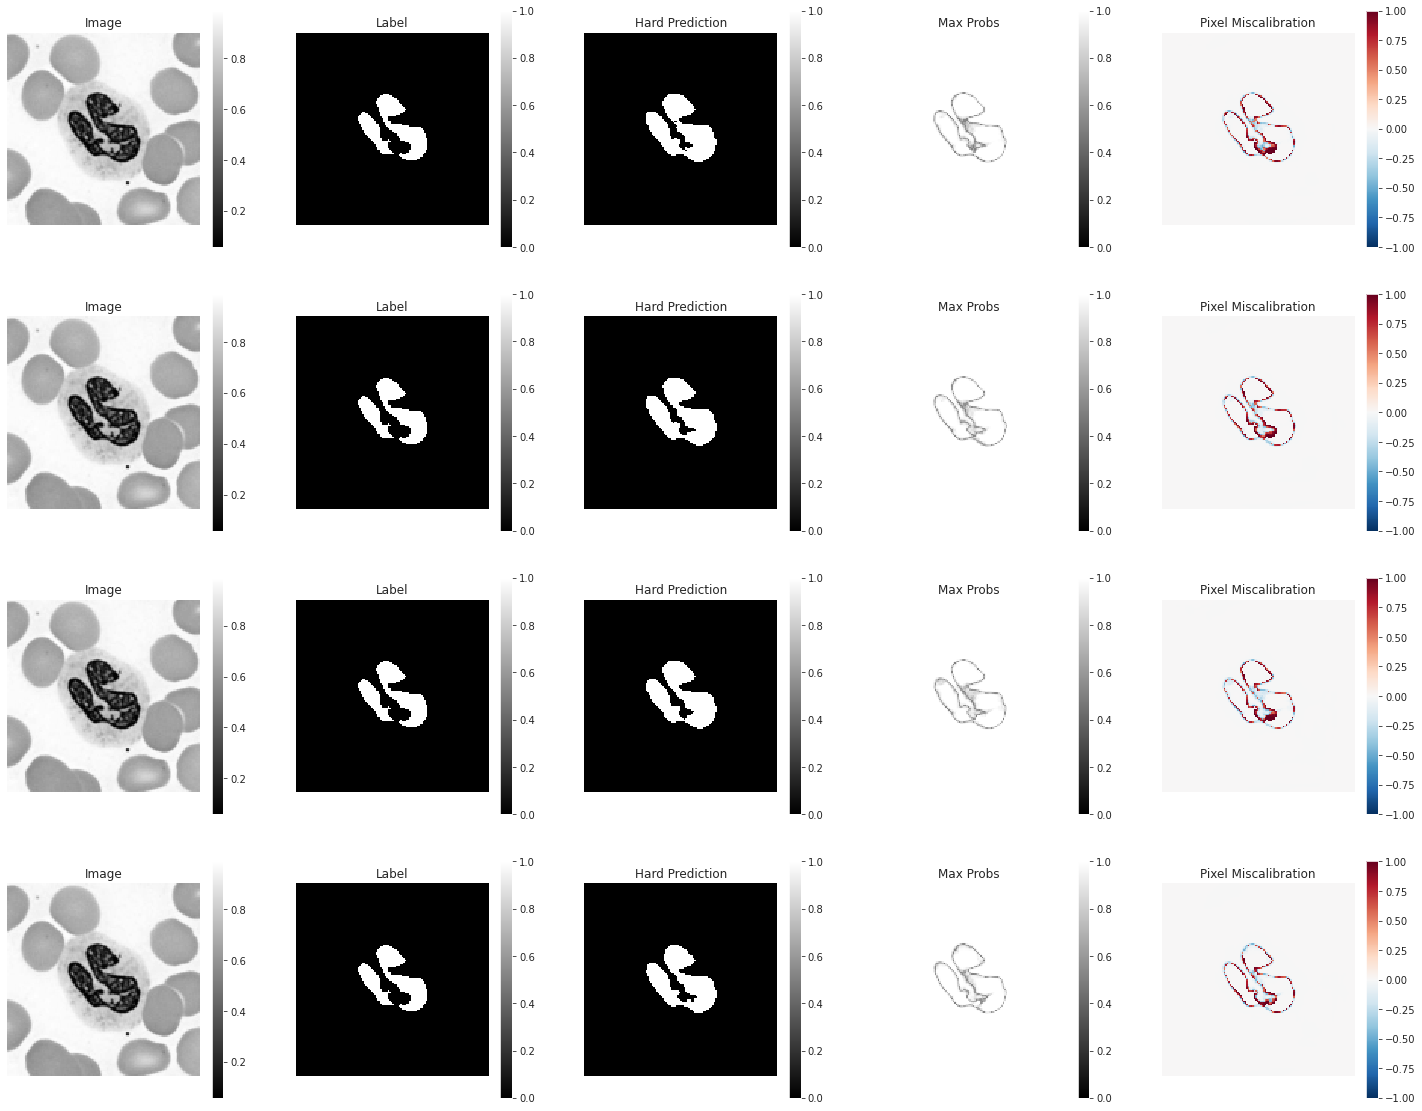

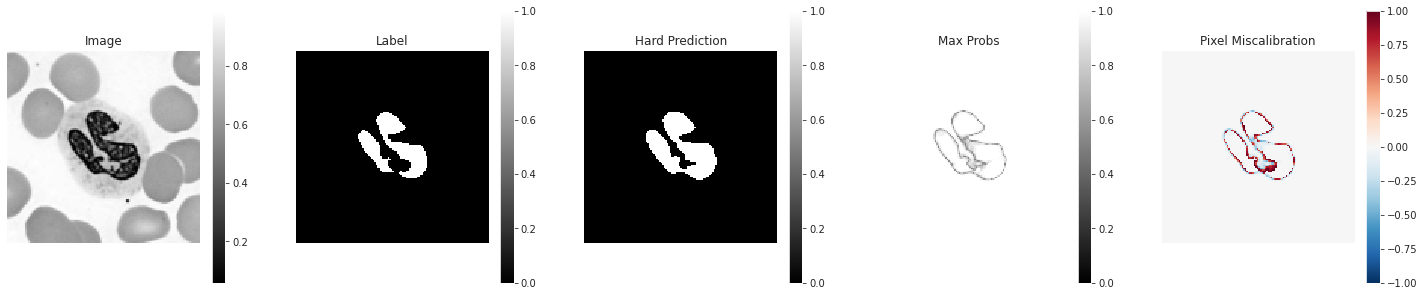

Dice: 0.8792372941970825
HD95: 2.0
BoundaryIOU: 0.709233820438385
Pixel-Ambiguity: 0.00025755396927706897
Soft-Region-Ambiguity: 0.001177571713924408
Hard-Region-Ambiguity: 0.0077667683362960815
Image_ECE: 0.0064737866341601944
Image_Edge-ECE: 0.18271655969823325
Local Bin counts:  tensor([[  778.,    88.,    60.,    38.,    26.,    30.,    19.,    23.,    25.,    27.,    21.,    24.,    51.,    51., 15123.],
        [15123.,    51.,    51.,    24.,    21.,    27.,    25.,    23.,    19.,    30.,    26.,    38.,    60.,    88.,   778.]], dtype=torch.float64)
Local Bin cal errors:  tensor([[    0.045,     0.370,     0.468,     0.555,     0.424,     0.439,     0.518,     0.329,     0.390,     0.325,     0.301,     0.192,     0.168,     0.099,     0.000],
        [    0.000,     0.099,     0.168,     0.192,     0.301,     0.325,     0.390,     0.329,     0.518,     0.439,     0.424,     0.555,     0.468,     0.370,     0.045]], dtype=torch.float64)
Image_CW-ECE: 0.012527486309409142
Local

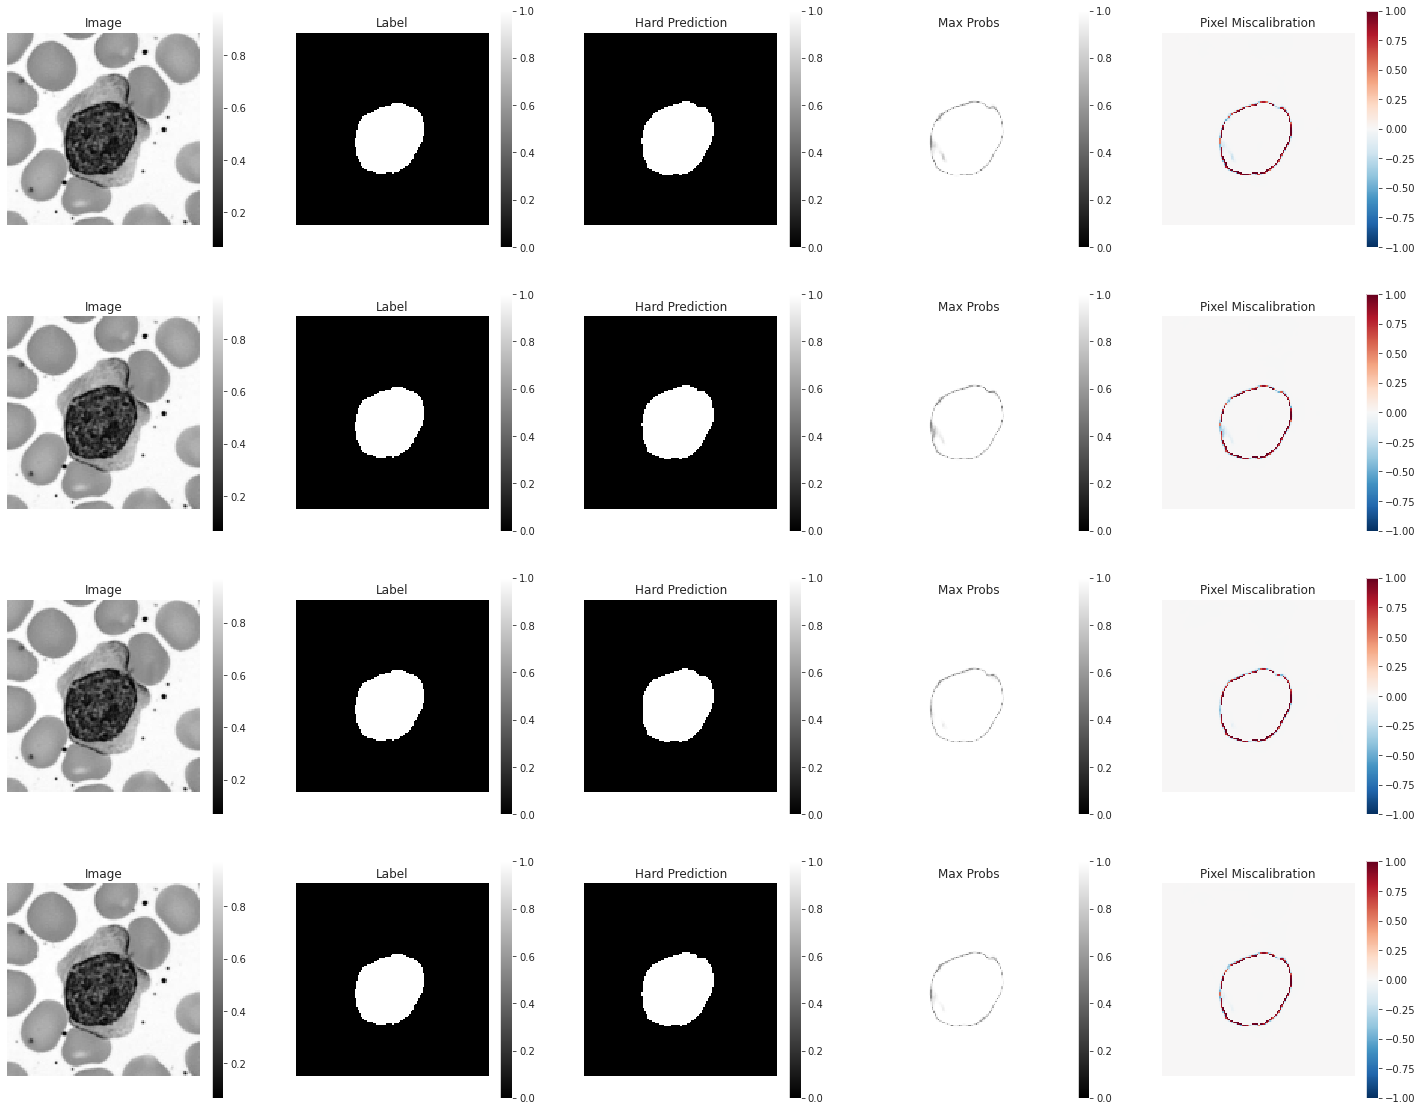

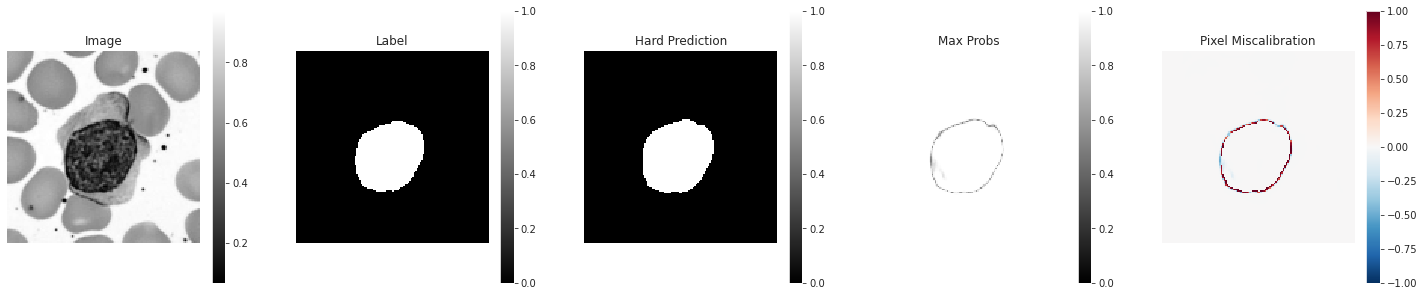

Dice: 0.9602534770965576
HD95: 1.4142135381698608
BoundaryIOU: 0.6895705461502075
Pixel-Ambiguity: 8.709394751349464e-05
Soft-Region-Ambiguity: 0.00022627413272857666
Hard-Region-Ambiguity: 0.0018676668405532837
Image_ECE: 0.005566394855122824
Image_Edge-ECE: 0.2679207051595052
Local Bin counts:  tensor([[    1699.,       41.,       20.,       15.,        5.,       10.,       12.,        8.,        7.,       14.,       12.,       13.,       15.,       24.,    14489.],
        [   14489.,       24.,       15.,       13.,       12.,       14.,        7.,        8.,       12.,       10.,        5.,       15.,       20.,       41.,     1699.]], dtype=torch.float64)
Local Bin cal errors:  tensor([[    0.036,     0.368,     0.537,     0.702,     0.702,     0.443,     0.486,     0.499,     0.435,     0.370,     0.301,     0.228,     0.167,     0.100,     0.000],
        [    0.000,     0.100,     0.167,     0.228,     0.301,     0.370,     0.435,     0.499,     0.486,     0.443,     0.702,   

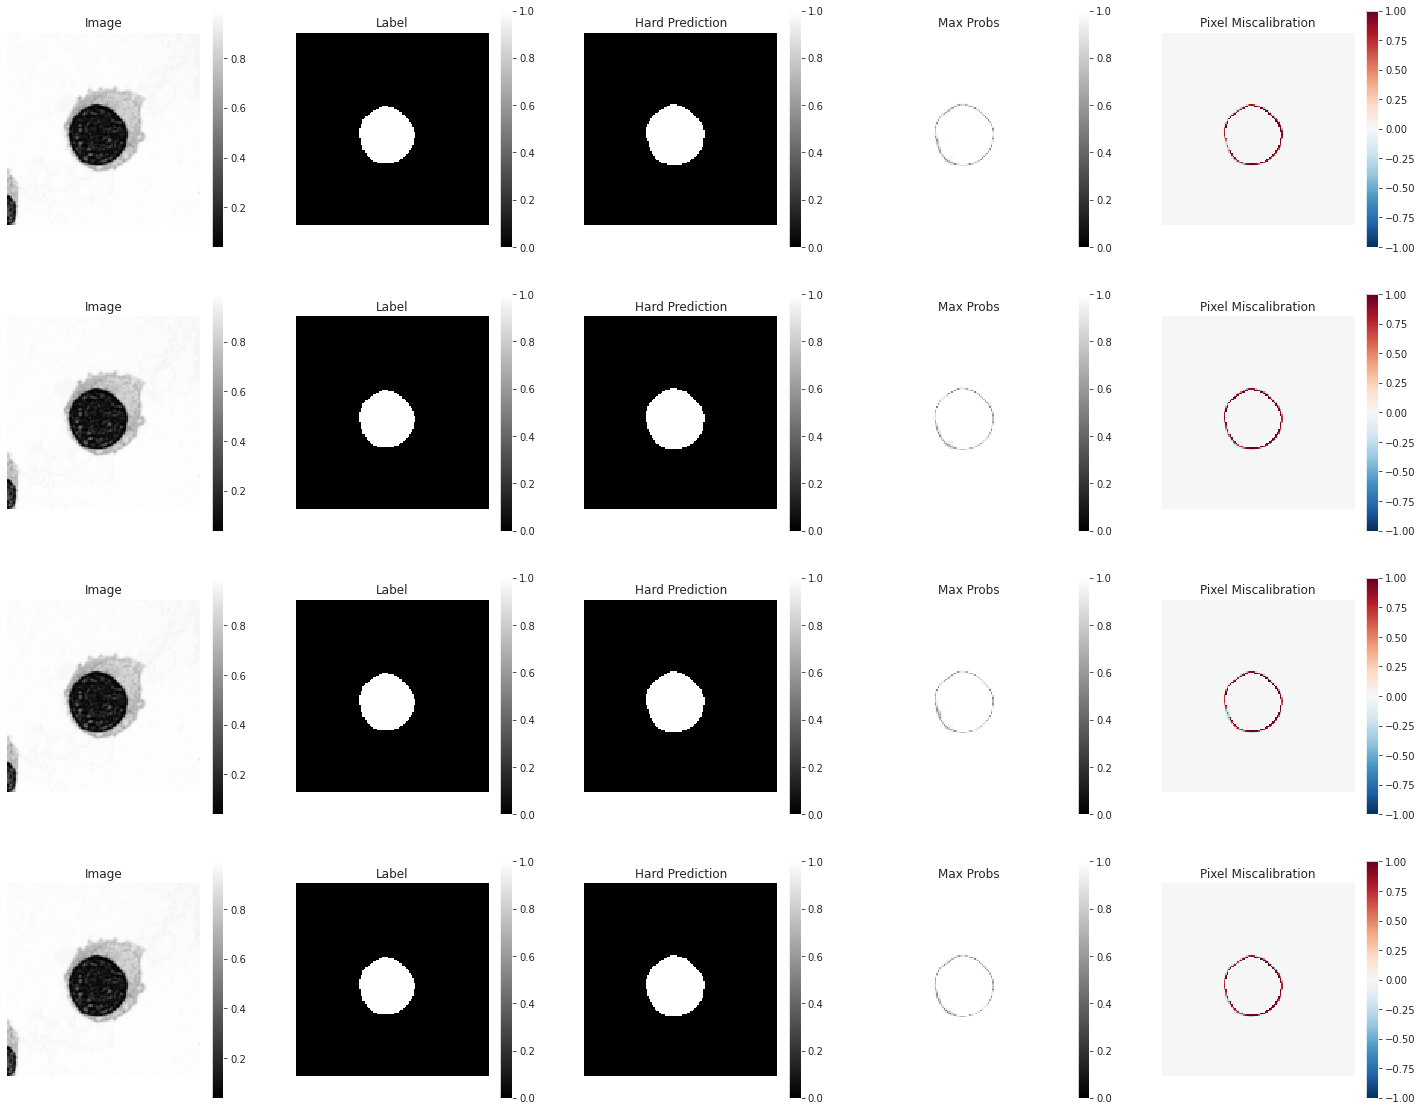

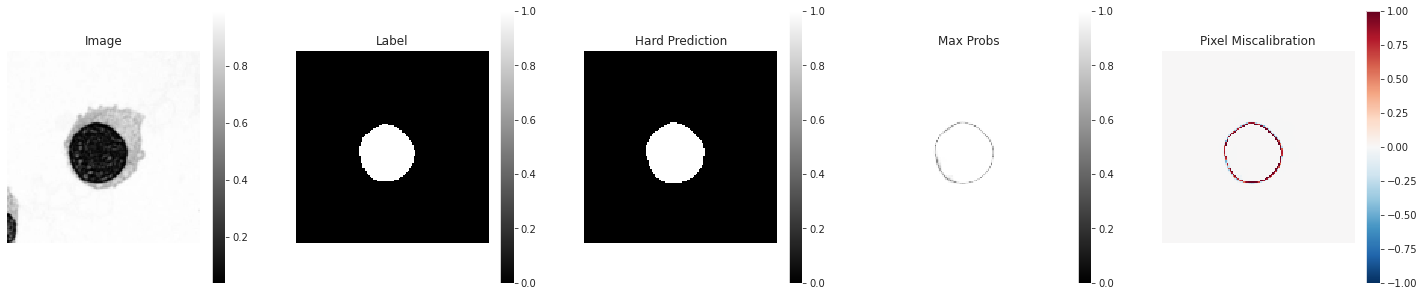

Dice: 0.9451627135276794
HD95: 1.4142135381698608
BoundaryIOU: 0.6748844385147095
Pixel-Ambiguity: 5.510566188604571e-05
Soft-Region-Ambiguity: 0.00021026283502578735
Hard-Region-Ambiguity: 0.0014221668243408203
Image_ECE: 0.005312555822456466
Image_Edge-ECE: 0.316710024078687
Local Bin counts:  tensor([[    1106.,       21.,       16.,       16.,        5.,        9.,        8.,        5.,        6.,        8.,       10.,       11.,        9.,       19.,    15135.],
        [   15135.,       19.,        9.,       11.,       10.,        8.,        6.,        5.,        8.,        9.,        5.,       16.,       16.,       21.,     1106.]], dtype=torch.float64)
Local Bin cal errors:  tensor([[    0.047,     0.666,     0.716,     0.714,     0.708,     0.646,     0.571,     0.490,     0.438,     0.359,     0.288,     0.235,     0.168,     0.092,     0.000],
        [    0.000,     0.092,     0.168,     0.235,     0.288,     0.359,     0.438,     0.490,     0.571,     0.646,     0.708,    

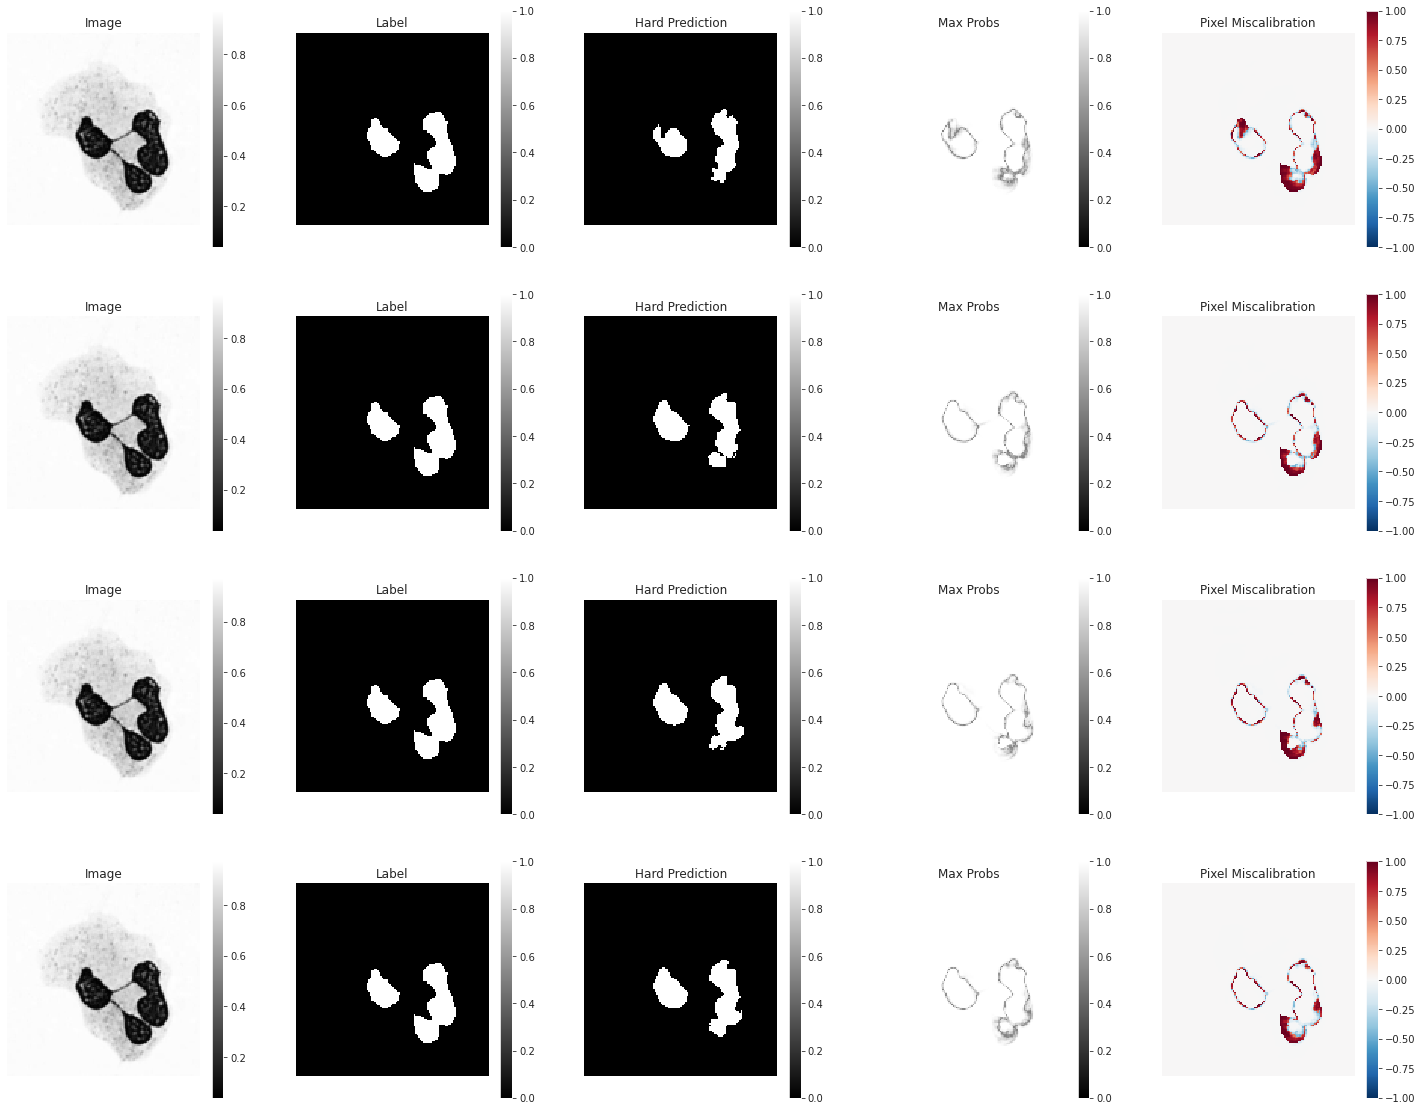

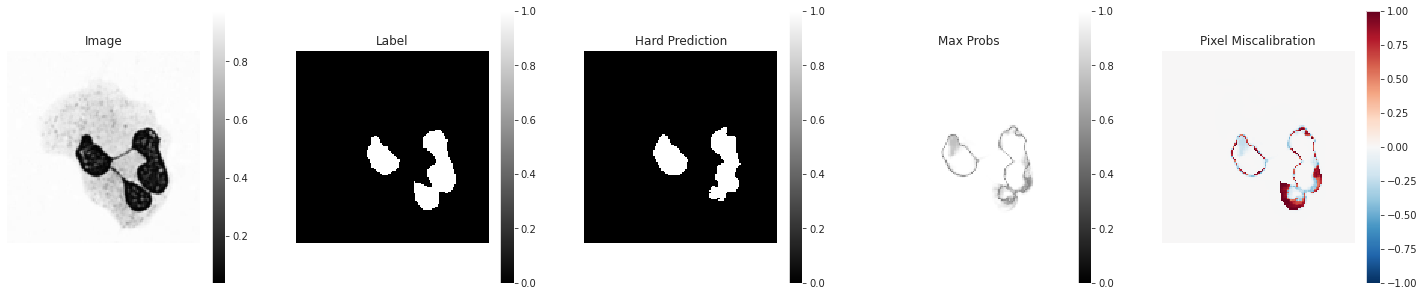

Dice: 0.8499534130096436
HD95: 5.099019527435303
BoundaryIOU: 0.6007004976272583
Pixel-Ambiguity: 0.0014428419526666403
Soft-Region-Ambiguity: 0.007193207740783691
Hard-Region-Ambiguity: 0.0223102867603302
Image_ECE: 0.010013667979364996
Image_Edge-ECE: 0.18295839840143258
Local Bin counts:  tensor([[  655.,    85.,    71.,   103.,    28.,    36.,    29.,    16.,    36.,    37.,    25.,    39.,    49.,    90., 15085.],
        [15085.,    90.,    49.,    39.,    25.,    37.,    36.,    16.,    29.,    36.,    28.,   103.,    71.,    85.,   655.]], dtype=torch.float64)
Local Bin cal errors:  tensor([[    0.021,     0.000,     0.078,     0.019,     0.048,     0.035,     0.014,     0.007,     0.232,     0.252,     0.100,     0.229,     0.426,     0.388,     0.004],
        [    0.004,     0.388,     0.426,     0.229,     0.100,     0.252,     0.232,     0.007,     0.014,     0.035,     0.048,     0.019,     0.078,     0.000,     0.021]], dtype=torch.float64)
Image_CW-ECE: 0.01047010347247

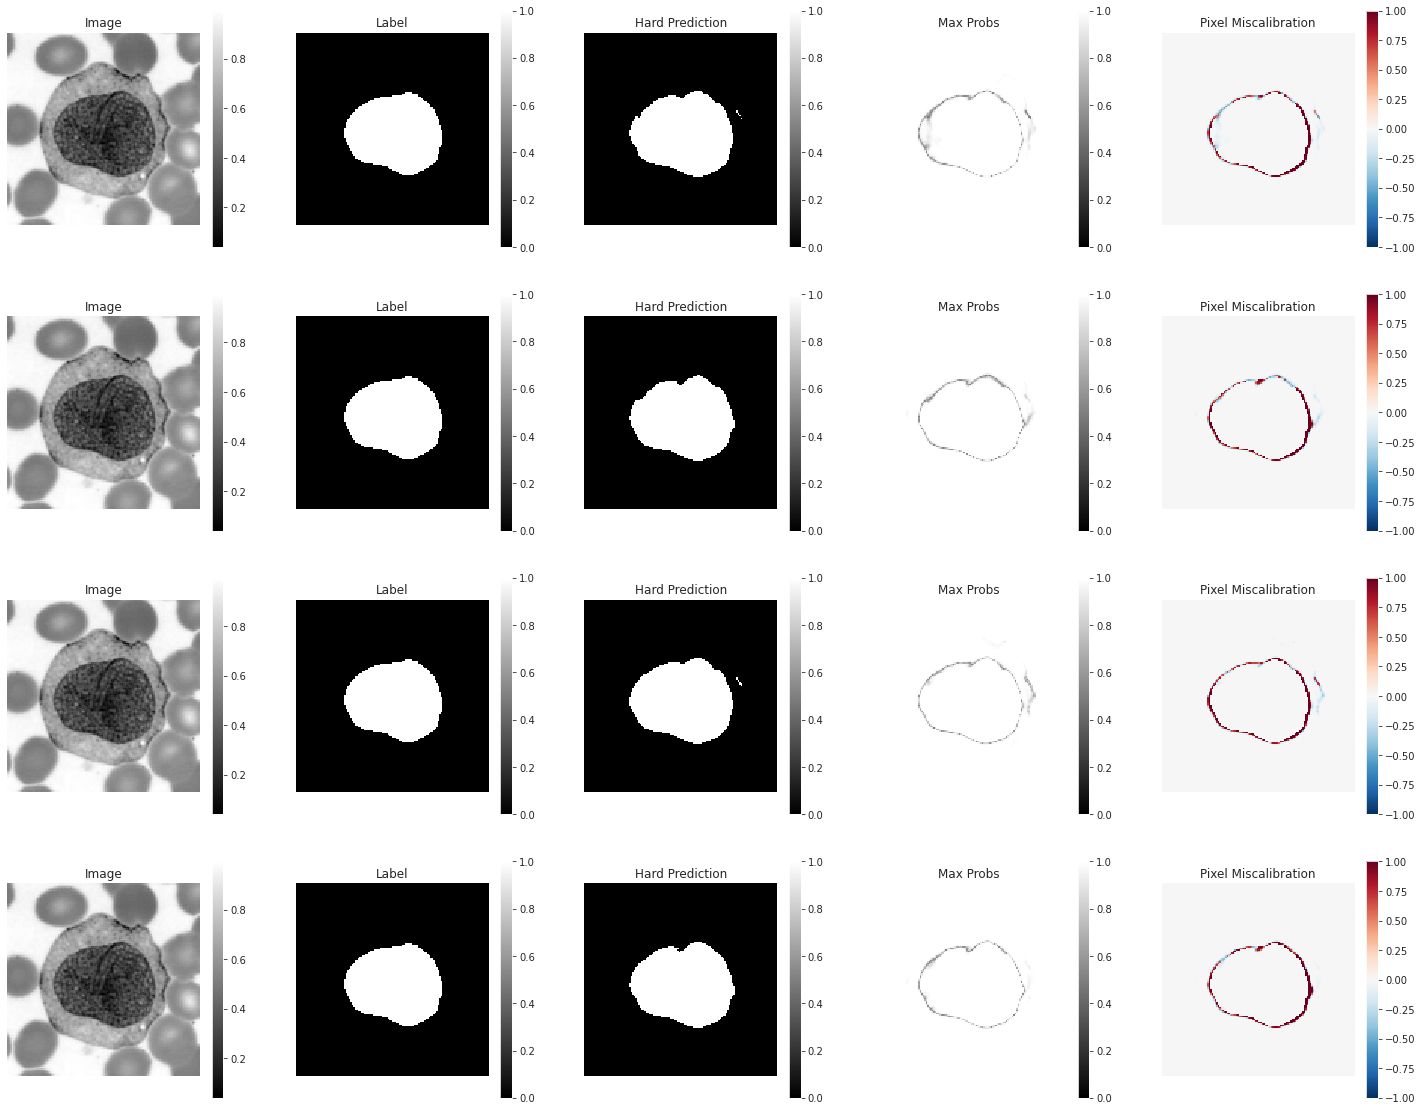

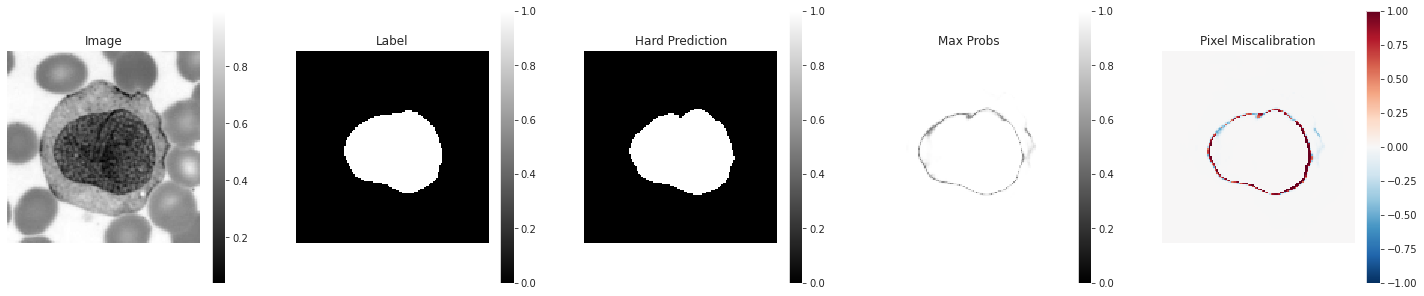

Dice: 0.9585884213447571
HD95: 2.1180338859558105
BoundaryIOU: 0.6276408433914185
Pixel-Ambiguity: 0.0004614859353750944
Soft-Region-Ambiguity: 0.0008114054799079895
Hard-Region-Ambiguity: 0.004239082336425781
Image_ECE: 0.008428881556028526
Image_Edge-ECE: 0.2886684708297253
Local Bin counts:  tensor([[    2710.,       54.,       27.,       22.,       22.,       25.,       12.,       23.,       15.,       12.,       22.,       16.,       30.,       69.,    13325.],
        [   13325.,       69.,       30.,       16.,       22.,       12.,       15.,       23.,       12.,       25.,       22.,       22.,       27.,       54.,     2710.]], dtype=torch.float64)
Local Bin cal errors:  tensor([[0.037, 0.402, 0.503, 0.453, 0.563, 0.227, 0.559, 0.239, 0.305, 0.367, 0.215, 0.234, 0.133, 0.067, 0.001],
        [0.001, 0.067, 0.133, 0.234, 0.215, 0.367, 0.305, 0.239, 0.559, 0.227, 0.563, 0.453, 0.503, 0.402, 0.037]], dtype=torch.float64)
Image_CW-ECE: 0.012904592789709568
Local Bin counts:  ten

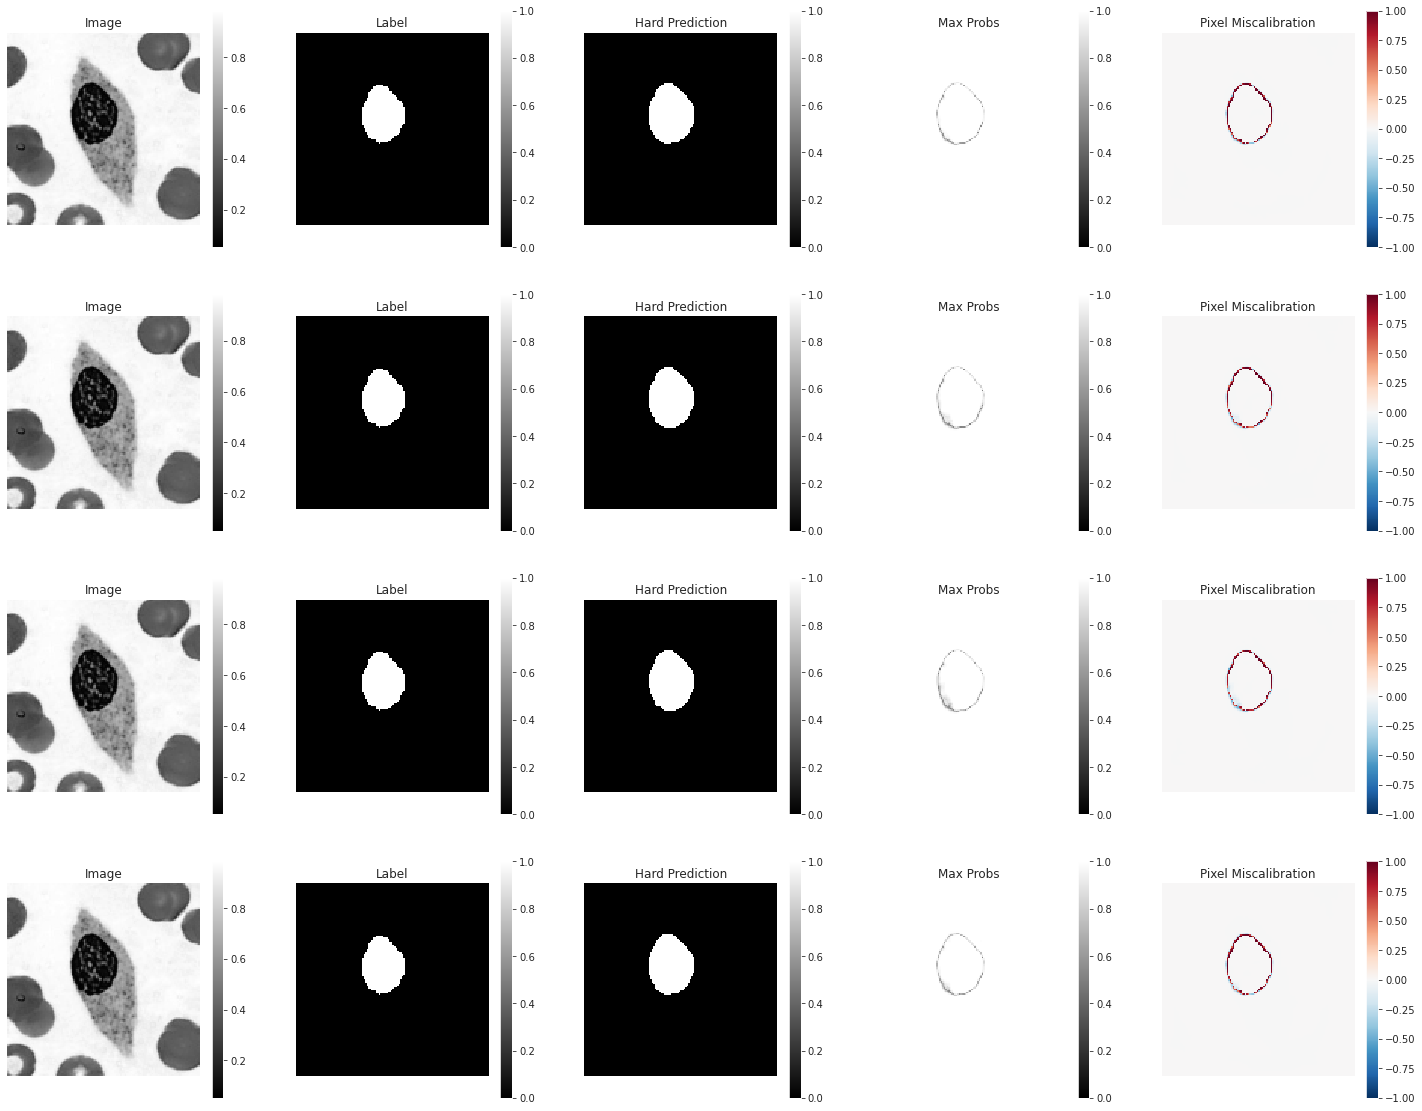

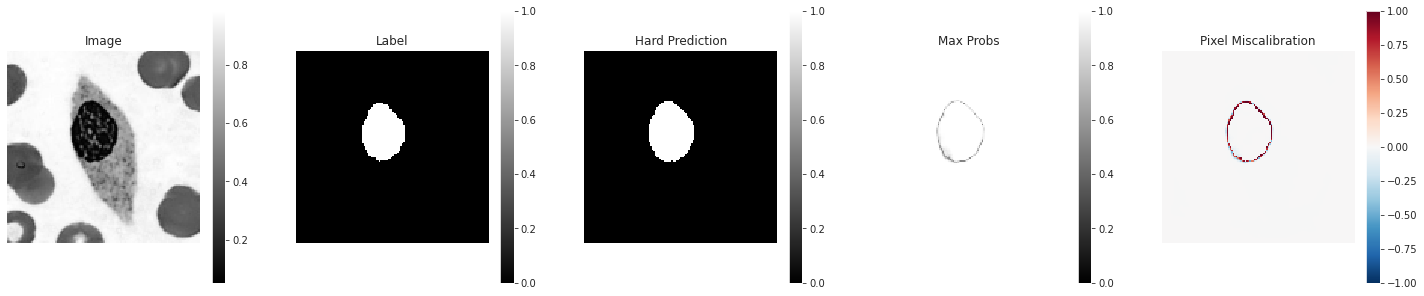

Dice: 0.9385150671005249
HD95: 1.4142135381698608
BoundaryIOU: 0.6813380122184753
Pixel-Ambiguity: 6.599276093766093e-05
Soft-Region-Ambiguity: 0.00032179057598114014
Hard-Region-Ambiguity: 0.0020995140075683594
Image_ECE: 0.004364075346529638
Image_Edge-ECE: 0.29683116580663105
Local Bin counts:  tensor([[     839.,       35.,       11.,       11.,        6.,        5.,        5.,        5.,        7.,        5.,        8.,       11.,        8.,       31.,    15397.],
        [   15397.,       31.,        8.,       11.,        8.,        5.,        7.,        5.,        5.,        5.,        6.,       11.,       11.,       35.,      839.]], dtype=torch.float64)
Local Bin cal errors:  tensor([[    0.054,     0.421,     0.833,     0.668,     0.703,     0.635,     0.578,     0.509,     0.431,     0.369,     0.293,     0.236,     0.167,     0.101,     0.000],
        [    0.000,     0.101,     0.167,     0.236,     0.293,     0.369,     0.431,     0.509,     0.578,     0.635,     0.703,  

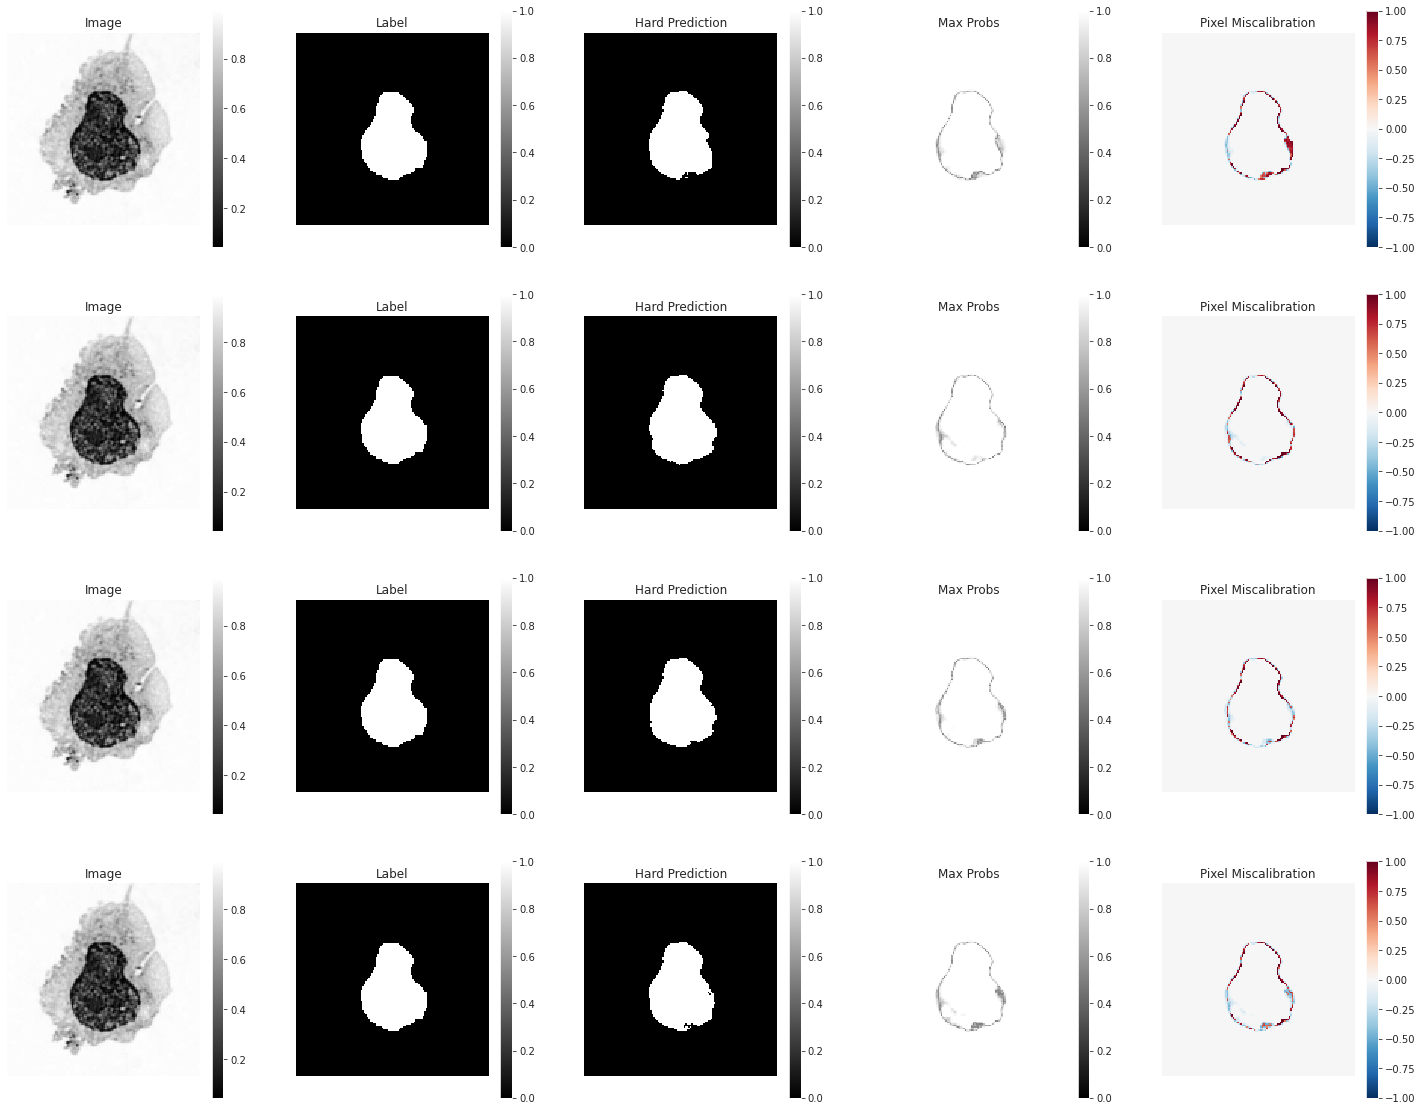

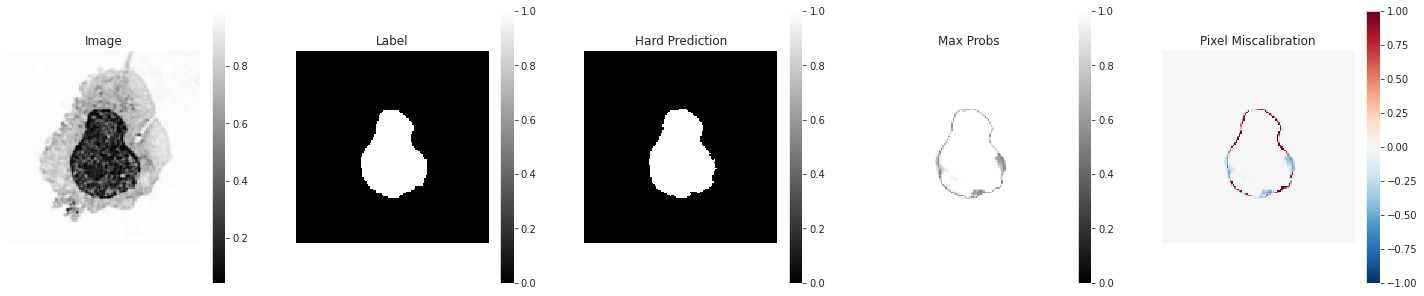

Dice: 0.9659598469734192
HD95: 1.4142135381698608
BoundaryIOU: 0.7412031888961792
Pixel-Ambiguity: 0.0005582832964137197
Soft-Region-Ambiguity: 0.0014598667621612549
Hard-Region-Ambiguity: 0.006713896989822388
Image_ECE: 0.0035269257532490814
Image_Edge-ECE: 0.1418871921128952
Local Bin counts:  tensor([[    1637.,       45.,       33.,       29.,       24.,       29.,       26.,       20.,       18.,       13.,       21.,       20.,       23.,       31.,    14415.],
        [   14415.,       31.,       23.,       20.,       21.,       13.,       18.,       20.,       26.,       29.,       24.,       29.,       33.,       45.,     1637.]], dtype=torch.float64)
Local Bin cal errors:  tensor([[    0.023,     0.196,     0.137,     0.010,     0.047,     0.081,     0.127,     0.005,     0.061,     0.370,     0.256,     0.137,     0.160,     0.066,     0.000],
        [    0.000,     0.066,     0.160,     0.137,     0.256,     0.370,     0.061,     0.005,     0.127,     0.081,     0.047,    

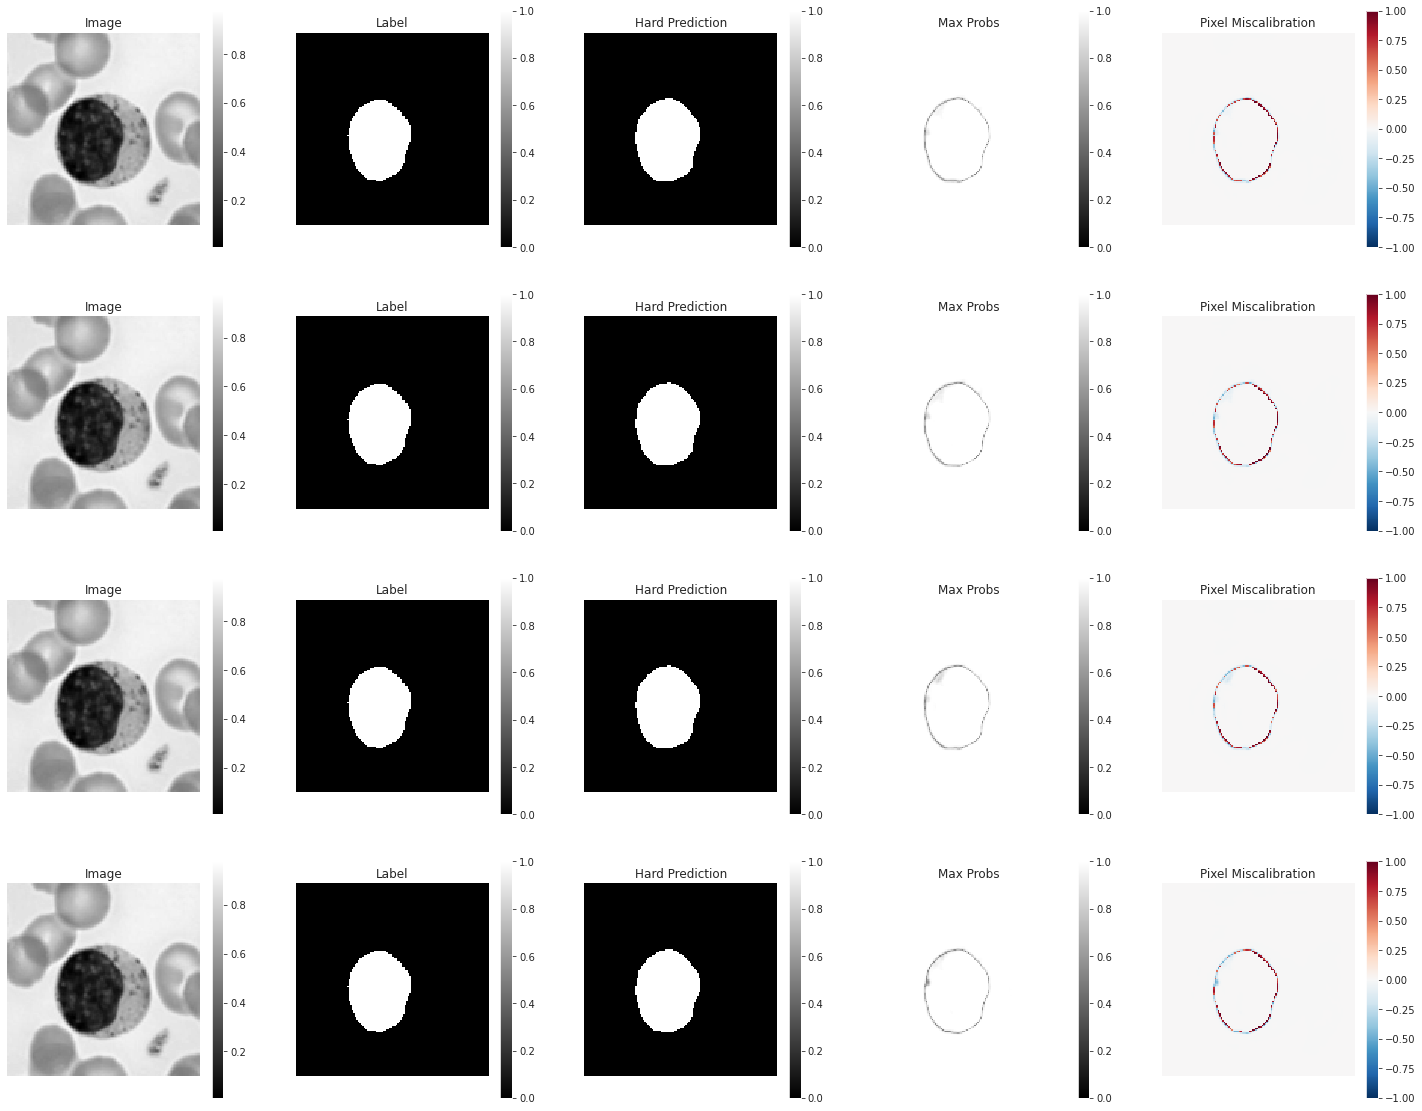

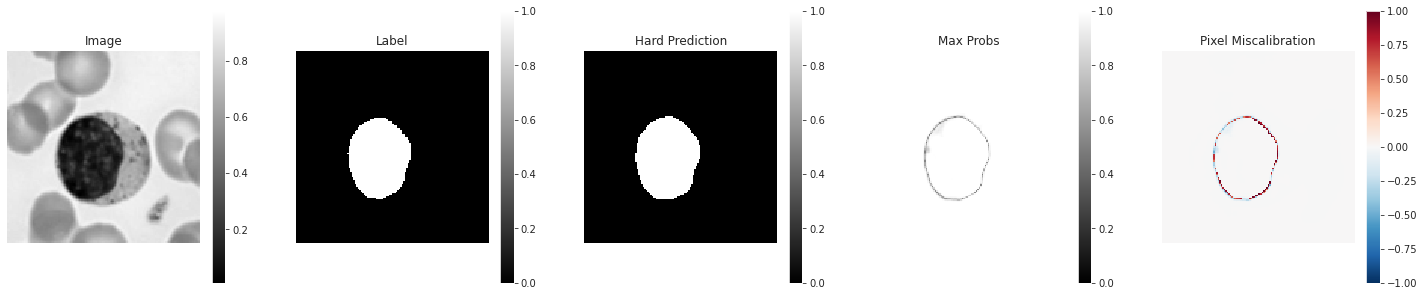

Dice: 0.9713312387466431
HD95: 1.0
BoundaryIOU: 0.7723270654678345
Pixel-Ambiguity: 8.178260759450495e-05
Soft-Region-Ambiguity: 0.0002132132649421692
Hard-Region-Ambiguity: 0.0017864108085632324
Image_ECE: 0.0024902574368751763
Image_Edge-ECE: 0.131452811915943
Local Bin counts:  tensor([[    1686.,       37.,       26.,       20.,       13.,       13.,       10.,       11.,        6.,       11.,       14.,       14.,       21.,       44.,    14458.],
        [   14458.,       44.,       21.,       14.,       14.,       11.,        6.,       11.,       10.,       13.,       13.,       20.,       26.,       37.,     1686.]], dtype=torch.float64)
Local Bin cal errors:  tensor([[    0.011,     0.175,     0.370,     0.467,     0.622,     0.475,     0.557,     0.505,     0.420,     0.364,     0.306,     0.228,     0.164,     0.096,     0.000],
        [    0.000,     0.096,     0.164,     0.228,     0.306,     0.364,     0.420,     0.505,     0.557,     0.475,     0.622,     0.467,     0.3

KeyboardInterrupt: 

In [13]:
from ese.experiment.experiment import run_ese_exp

###### Run individual jobs
run_ese_exp(
    config=cfgs[0], 
    job_func=get_cal_stats,
    run_name='debug',
    show_examples=True,
    gpu='3',
) 

In [ ]:
# from ese.experiment.experiment import submit_ese_exps 

# #### Run Batch Jobs
# submit_ese_exps(
#     config_list=cfgs,
#     job_func=get_cal_stats,
#     # available_gpus=['0', '1', '2', '3'],
#     available_gpus=['0', '1', '2', '3', '4', '5', '6', '7'],
# )